In this example we show how a CNN can be used to reconstruct an image from a sinogram using self-supervised learning. 
The CNN takes the original sinogram as an input and creates a reconstructed image that generates a sinogram (radon transform) that matches the original sinogram.
We are using only one sinogram here which is not fair; we should be using 1,000 - 10,000s of sinograms to see if the autoencoder can learn to perform sinogram to image (i.e. change domains)

First we import all necessary modules

In [1]:
from nDTomo.sim.shapes.phantoms import SheppLogan
from nDTomo.utils.misc import showim
from nDTomo.ct.conv_tomo import fbpvol, sinocentering

from nDTomo.nn.models_tf import DCNN2D
from nDTomo.nn.utils_tf import tf_gpu_devices, ReduceLROnPlateau_custom
from nDTomo.nn.tomo_tf import tf_create_angles, tf_tomo_transf, tf_tomo_radon, tf_tomo_squeeze, tf_tomo_bp, tf_mask_circle
from nDTomo.nn.losses_tf import ssim_mae_loss

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf


Check if Tensorflow will run on GPU

In [2]:

tf_gpu_devices()

physical_devices = tf.config.list_physical_devices('GPU') 

print(physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Let's create a Shepp-Logan phantom

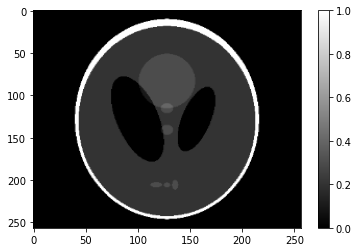

In [3]:
npix = 257
im = SheppLogan(npix)

showim(im, 1, cmap = 'gray')


Calculate the radon transform or sinogram

(1, 257, 257, 1)
(1, 257, 257, 1)


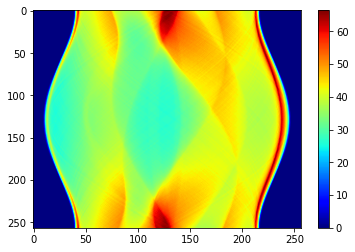

In [4]:
nproj = np.round(npix/1)
theta = tf_create_angles(nproj)

imtf = tf_tomo_transf(im)
print(imtf.shape)

sino = tf_tomo_radon(imtf, theta, interp_method='bilinear')
print(sino.shape)

showim(tf_tomo_squeeze(sino), 2)

Reconstruct using the filtered back projection algorithm

The dimensions of the reconstructed volume are  (257, 257)


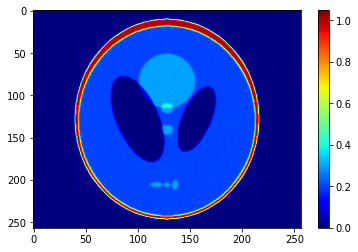

In [5]:
s = np.array(sino[0,:,:,0]).transpose()

fbp = fbpvol(s, theta=np.rad2deg(theta), nt = im.shape[0])
showim(fbp, 3, clim=(0, np.max(fbp)))

Let's create a 2D Autoencoder CNN

In [6]:
model = DCNN2D(npix, nlayers=3, net='autoencoder', dropout='No', batchnorm = 'No', 
                filtnums=64, nconvs=3, actlayerfi = 'linear', skipcon = 'No', dlayer = 'No')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 257, 257, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 257, 257, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 257, 257, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 257, 257, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 129, 129, 64)      36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 129, 129, 64)      36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 129, 129, 64)      36928 

Now we perform the training of the self-supervised CNN

In [7]:
epochs = 4001
save_interval = 100
lr_interval = 300

optimizer = tf.keras.optimizers.Adam(0.001)

reduce_rl_plateau = ReduceLROnPlateau_custom(patience=int(lr_interval/save_interval),
                                factor=0.5,
                                verbose=1, 
                                optim_lr=optimizer.learning_rate, 
                                reduce_lin=True)

loss = []

reduce_rl_plateau.on_train_begin()

kk = 1
for epoch in tqdm(range(epochs)):

    start = time.time()
    
    with tf.GradientTape(persistent=True) as tape:
        
        generated_img = model(sino)
        
        generated_img = tf.abs(generated_img)
        
        gen_sino = tf_tomo_radon(generated_img, theta, tile=True)

        nnet_loss = ssim_mae_loss(tf.cast(sino, tf.float32), gen_sino)
                
    grad_nnet = tape.gradient(nnet_loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grad_nnet, model.trainable_variables))    
    
    loss.append(nnet_loss)

    if epoch % save_interval == 0 and epoch != 0:
            
        print('Time for epoch {} to {} is {} sec/it - gen_loss = {}'.format(epoch - save_interval + 1, epoch, time.time() - start, nnet_loss))

        reduce_rl_plateau.on_epoch_end(kk, nnet_loss)
    
        kk = kk + 1



  3%|▎         | 103/4001 [00:10<04:57, 13.12it/s]

Time for epoch 1 to 100 is 0.07522273063659668 sec/it - gen_loss = 1.8877218961715698


  5%|▌         | 203/4001 [00:17<04:40, 13.53it/s]

Time for epoch 101 to 200 is 0.0754997730255127 sec/it - gen_loss = 1.6771297454833984


  8%|▊         | 303/4001 [00:25<04:39, 13.21it/s]

Time for epoch 201 to 300 is 0.07650136947631836 sec/it - gen_loss = 1.7826476097106934


 10%|█         | 403/4001 [00:32<04:38, 12.91it/s]

Time for epoch 301 to 400 is 0.07549905776977539 sec/it - gen_loss = 1.6759414672851562


 13%|█▎        | 503/4001 [00:40<04:27, 13.07it/s]

Time for epoch 401 to 500 is 0.07400012016296387 sec/it - gen_loss = 1.3374004364013672


 15%|█▌        | 603/4001 [00:48<04:18, 13.16it/s]

Time for epoch 501 to 600 is 0.07349896430969238 sec/it - gen_loss = 1.7021901607513428


 18%|█▊        | 703/4001 [00:55<04:14, 12.97it/s]

Time for epoch 601 to 700 is 0.07500123977661133 sec/it - gen_loss = 2.307459592819214


 20%|██        | 803/4001 [01:03<04:04, 13.10it/s]

Time for epoch 701 to 800 is 0.07349991798400879 sec/it - gen_loss = 2.360116481781006

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


 23%|██▎       | 903/4001 [01:11<04:00, 12.90it/s]

Time for epoch 801 to 900 is 0.07450008392333984 sec/it - gen_loss = 1.8909680843353271


 25%|██▌       | 1003/4001 [01:18<03:48, 13.11it/s]

Time for epoch 901 to 1000 is 0.07700157165527344 sec/it - gen_loss = 1.6474350690841675


 28%|██▊       | 1103/4001 [01:26<03:42, 13.05it/s]

Time for epoch 1001 to 1100 is 0.07549786567687988 sec/it - gen_loss = 1.7610068321228027

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


 30%|███       | 1203/4001 [01:34<03:33, 13.13it/s]

Time for epoch 1101 to 1200 is 0.0774993896484375 sec/it - gen_loss = 1.4787139892578125


 33%|███▎      | 1303/4001 [01:41<03:30, 12.83it/s]

Time for epoch 1201 to 1300 is 0.07649946212768555 sec/it - gen_loss = 1.312742829322815


 35%|███▌      | 1403/4001 [01:49<03:21, 12.92it/s]

Time for epoch 1301 to 1400 is 0.07600021362304688 sec/it - gen_loss = 1.348570704460144


 38%|███▊      | 1503/4001 [01:57<03:12, 12.98it/s]

Time for epoch 1401 to 1500 is 0.07799983024597168 sec/it - gen_loss = 1.1523511409759521


 40%|████      | 1603/4001 [02:05<03:05, 12.94it/s]

Time for epoch 1501 to 1600 is 0.0794985294342041 sec/it - gen_loss = 1.1797676086425781


 43%|████▎     | 1703/4001 [02:12<02:55, 13.09it/s]

Time for epoch 1601 to 1700 is 0.0740976333618164 sec/it - gen_loss = 1.252401351928711


 45%|████▌     | 1803/4001 [02:20<02:46, 13.21it/s]

Time for epoch 1701 to 1800 is 0.0729985237121582 sec/it - gen_loss = 0.9857900738716125


 48%|████▊     | 1903/4001 [02:27<02:33, 13.67it/s]

Time for epoch 1801 to 1900 is 0.07150053977966309 sec/it - gen_loss = 0.96184241771698


 50%|█████     | 2003/4001 [02:35<02:36, 12.74it/s]

Time for epoch 1901 to 2000 is 0.0775003433227539 sec/it - gen_loss = 1.192272424697876


 53%|█████▎    | 2103/4001 [02:43<02:24, 13.10it/s]

Time for epoch 2001 to 2100 is 0.07600069046020508 sec/it - gen_loss = 0.8051302433013916


 55%|█████▌    | 2203/4001 [02:50<02:18, 13.02it/s]

Time for epoch 2101 to 2200 is 0.07700037956237793 sec/it - gen_loss = 0.7608124017715454


 58%|█████▊    | 2303/4001 [02:58<02:08, 13.22it/s]

Time for epoch 2201 to 2300 is 0.07650041580200195 sec/it - gen_loss = 0.7089017629623413


 60%|██████    | 2403/4001 [03:05<01:58, 13.54it/s]

Time for epoch 2301 to 2400 is 0.07149982452392578 sec/it - gen_loss = 0.6508159637451172


 63%|██████▎   | 2503/4001 [03:13<01:56, 12.89it/s]

Time for epoch 2401 to 2500 is 0.07549858093261719 sec/it - gen_loss = 0.7034380435943604


 65%|██████▌   | 2603/4001 [03:22<01:50, 12.63it/s]

Time for epoch 2501 to 2600 is 0.07599902153015137 sec/it - gen_loss = 0.7104857563972473


 68%|██████▊   | 2703/4001 [03:30<01:41, 12.85it/s]

Time for epoch 2601 to 2700 is 0.07600140571594238 sec/it - gen_loss = 0.6449018716812134


 70%|███████   | 2803/4001 [03:38<01:31, 13.07it/s]

Time for epoch 2701 to 2800 is 0.07449984550476074 sec/it - gen_loss = 0.5561079382896423


 73%|███████▎  | 2903/4001 [03:45<01:22, 13.33it/s]

Time for epoch 2801 to 2900 is 0.07350397109985352 sec/it - gen_loss = 0.5425350666046143


 75%|███████▌  | 3003/4001 [03:53<01:16, 12.97it/s]

Time for epoch 2901 to 3000 is 0.07650113105773926 sec/it - gen_loss = 0.5141509175300598


 78%|███████▊  | 3103/4001 [04:00<01:07, 13.30it/s]

Time for epoch 3001 to 3100 is 0.07635712623596191 sec/it - gen_loss = 0.4591481685638428


 80%|████████  | 3203/4001 [04:08<01:00, 13.21it/s]

Time for epoch 3101 to 3200 is 0.07350015640258789 sec/it - gen_loss = 0.4229222536087036


 83%|████████▎ | 3303/4001 [04:16<00:51, 13.61it/s]

Time for epoch 3201 to 3300 is 0.07299923896789551 sec/it - gen_loss = 0.4218228757381439


 85%|████████▌ | 3403/4001 [04:23<00:44, 13.45it/s]

Time for epoch 3301 to 3400 is 0.07100105285644531 sec/it - gen_loss = 0.47282299399375916


 88%|████████▊ | 3503/4001 [04:31<00:38, 12.98it/s]

Time for epoch 3401 to 3500 is 0.07650017738342285 sec/it - gen_loss = 0.5607937574386597


 90%|█████████ | 3603/4001 [04:39<00:30, 12.99it/s]

Time for epoch 3501 to 3600 is 0.07499837875366211 sec/it - gen_loss = 0.4235824644565582

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


 93%|█████████▎| 3703/4001 [04:46<00:22, 12.96it/s]

Time for epoch 3601 to 3700 is 0.07649874687194824 sec/it - gen_loss = 0.3366401493549347


 95%|█████████▌| 3803/4001 [04:54<00:15, 13.19it/s]

Time for epoch 3701 to 3800 is 0.07500004768371582 sec/it - gen_loss = 0.3400779366493225


 98%|█████████▊| 3903/4001 [05:02<00:07, 13.14it/s]

Time for epoch 3801 to 3900 is 0.07699990272521973 sec/it - gen_loss = 0.3417705297470093


100%|██████████| 4001/4001 [05:09<00:00, 12.93it/s]

Time for epoch 3901 to 4000 is 0.07500004768371582 sec/it - gen_loss = 0.3198273479938507


Let's create now the CNN reconstructed image and compare it with the FBP algorithm

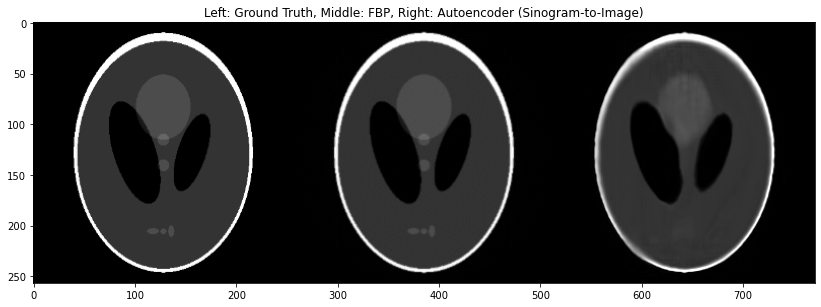

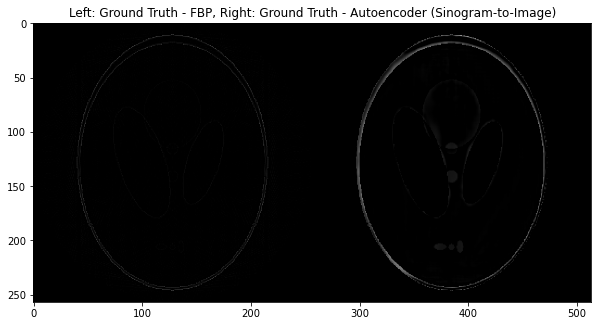

In [10]:
generated_img = model(sino)
generated_img = tf.abs(generated_img)
generated_img = tf_mask_circle(generated_img, npix=0)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(np.concatenate((im, fbp, generated_img[0,:,:,0]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth, Middle: FBP, Right: Autoencoder (Sinogram-to-Image)')
plt.show()

plt.figure(2, figsize=(10,10));plt.clf()
plt.imshow(np.concatenate((im - fbp, im - generated_img[0,:,:,0]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth - FBP, Right: Ground Truth - Autoencoder (Sinogram-to-Image)')
plt.show()

Let's calculate some metrics to compare the FBP and CNN reconstructions

In [11]:
imtf = np.reshape(im, (1, im.shape[0], im.shape[1],1))
imfbp = np.reshape(fbp, (1, fbp.shape[0], fbp.shape[1],1))

maeFBP = tf.reduce_mean(tf.keras.losses.MAE(im, fbp)).numpy()
maeCNN = tf.reduce_mean(tf.keras.losses.MAE(im, generated_img[0,:,:,0])).numpy()

mseFBP = tf.reduce_mean(tf.keras.losses.MSE(im, fbp)).numpy()
mseCNN = tf.reduce_mean(tf.keras.losses.MSE(im, generated_img[0,:,:,0])).numpy()

psnrFBP = tf.image.psnr(imtf, imfbp, 1).numpy()
psnrCNN = tf.image.psnr(imtf, generated_img, 1).numpy()

ssimFBP = tf.image.ssim(imtf, imfbp, 1).numpy()
ssimCNN = tf.image.ssim(imtf, np.array(generated_img, dtype='float64'), 1).numpy()

print(maeFBP, maeCNN)
print(mseFBP, mseCNN)
print(psnrFBP, psnrCNN)
print(ssimFBP, ssimCNN)


0.009661197566735464 0.017144753
0.0007830300505307404 0.0032232737
[31.062214] [24.917027]
[0.95534176] [0.92200124]
